In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

In [ ]:
# # Giving an input text, in live project: recognized by the speech to text recognition
# inputText = input()

In [ ]:
# Importing Conversatons dataset as a dataframe -> This can be considered as a stream in live project
df_conversations = pd.read_excel('Data_1.xlsx')

In [ ]:
df_conversations['Speaker'] = [int(i) for i in df_conversations['Speaker']]

In [ ]:
df_conversations.head()

,Speaker,Text
0,0,I can’t believe I’m sitting here next to littl...
1,1,"Well, you are."
2,0,Little Lalita. That’s kind of fun to say. Litt...
3,1,"No, it's okay."
4,0,You have lost so much weight! That must have b...


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
class contextualSpeakerStates:
  def __init__(self, dataset):
    self.dataset = dataset
    # Obtaining the Text column of the dataset as a list of all texts
    self.listOfTexts = list(self.dataset['Text'])
    # Creating the train data, i.e., tokenized version of the wholeText
    self.trainData = [text.split() for text in self.listOfTexts]
    # Building Word2Vec Model on the basis of wholeText
    self.model = Word2Vec(self.trainData, min_count=1)
    self.listOfSpeakerStates = list(set(list(self.dataset['Speaker'])))

  def getSpeakerSpecificDialogues(self):
    dialogues = {}
    # Obtaining the list of existing speaker states in the Speaker column of dataframe
    for state in self.listOfSpeakerStates:
      dialogues[state] = [self.dataset['Text'][i] for i in range(len(self.dataset)) if self.dataset['Speaker'][i]==state]
    # Return the mapped dictionary i.e., dialogues with key:pair as speaker:texts
    return dialogues

  def getTransitionMatrix(self, speakerSpecificDialogues):
    aggregatedTextListBySpeakers = {}
    
    # Forming the aggregated Text Lists for each speaker, i.e., combining all the texts for a speaker into a single text
    for state in self.listOfSpeakerStates:
      temp = ' '.join(speakerSpecificDialogues[state])
      aggregatedTextListBySpeakers[state] = temp

    # Forming the transition matrix
    transitionMatrix = []
    for state1 in self.listOfSpeakerStates:
      tempDistances = []
      for state2 in self.listOfSpeakerStates:
        # Using the Word Mover's Distance
        tempDistances.append(self.model.wv.wmdistance(aggregatedTextListBySpeakers[state1], aggregatedTextListBySpeakers[state2]))
      transitionMatrix.append(tempDistances)
    
    return transitionMatrix

  def getConversationDistances(self, speakerSpecificDialogues, inputText):
    # Obtaining the averaged vector of speaker-specific minimum distances

    # distances dictionary
    distances = {}

    # Initialize empty lists
    for state in self.listOfSpeakerStates:
      distances[state] = []

    for state in self.listOfSpeakerStates:
      for dialogue in speakerSpecificDialogues[state]:
        distance = self.model.wv.wmdistance(inputText, dialogue)
        distances[state].append(distance)
    return distances

  def getAveragedDistancesVector(self, distances):
    # Filtering out infinity and nan values to make sure our found average is correct and we don't consider the outliers
    for state in distances.keys():
      distances[state] = [distances[state][i] for i in range(len(distances[state])) if distances[state][i]!=np.inf and distances[state][i]!=np.nan]
    averagedDistancesVector = [np.mean(distances[state]) for state in range(min(self.listOfSpeakerStates), max(self.listOfSpeakerStates)+1)]
    return averagedDistancesVector
  
  def identifiedSpeaker(self, averagedDistancesVector):
    return self.listOfSpeakerStates[averagedDistancesVector.index(min(averagedDistancesVector))]

  def predictSpeaker(self, averagedDistancesVector, transitionMatrix):
    obtainedDotProductVector = np.dot(averagedDistancesVector, transitionMatrix)
    return self.listOfSpeakerStates[list(obtainedDotProductVector).index(min(list(obtainedDotProductVector)))]

  def update(self, dataset):
    self.dataset = dataset
    # Obtaining the Text column of the dataset as a list of all texts
    self.listOfTexts = list(self.dataset['Text'])
    # Creating the train data, i.e., tokenized version of the wholeText
    self.trainData = [text.split() for text in self.listOfTexts]
    # Building Word2Vec Model on the basis of wholeText
    self.model.build_vocab(self.trainData, update=True)
    token_count = len(self.trainData[-1])
    self.model.train(self.trainData, total_examples = token_count, epochs=self.model.epochs)
    self.listOfSpeakerStates = list(set(list(self.dataset['Speaker'])))

In [ ]:
contextualSpeakerStatesObject = contextualSpeakerStates(df_conversations[:2])

In [ ]:
def speakerValidationAndPrediction(SpeakerDiarizationSpeakerIdentity, inputText, data):
  contextualSpeakerStatesObject.update(data)
  speakerSpecificDialogues = contextualSpeakerStatesObject.getSpeakerSpecificDialogues()
  transitionMatrix = contextualSpeakerStatesObject.getTransitionMatrix(speakerSpecificDialogues)
  distances = contextualSpeakerStatesObject.getConversationDistances(speakerSpecificDialogues, inputText)
  averagedDistancesVector = contextualSpeakerStatesObject.getAveragedDistancesVector(distances)
  identifiedSpeaker = contextualSpeakerStatesObject.identifiedSpeaker(averagedDistancesVector)
  if identifiedSpeaker==SpeakerDiarizationSpeakerIdentity:
    predictedSpeaker = contextualSpeakerStatesObject.predictSpeaker(averagedDistancesVector, transitionMatrix)
    # Dataset Updation process
    ###

    return predictedSpeaker
  else:
    # Dataset Updation process
    return -1

In [ ]:
percentages_list = []
ths_list = []
predictionsList = []
predictionsPercentageList = []

for ths in range(5, len(df_conversations), 5):
  p_list = []
  predictions_count = 0
  correct_predictions_count = 0
  for i in range(3, len(df_conversations)):
    try:
      inputText = df_conversations.iloc[i]['Text']
      speaker = int(df_conversations.iloc[i]['Speaker'])
      if i<ths+1:
        prediction = speakerValidationAndPrediction(speaker, inputText, df_conversations[:i])
      else:
        prediction = speakerValidationAndPrediction(speaker, inputText, df_conversations[i-ths:i])
      # prediction = speakerValidationAndPrediction(speaker, inputText, df_conversations[:i])
      if prediction>=0:
        p_list.append(prediction)
        predictions_count += 1
        actualSpeaker = int(df_conversations.iloc[i+1]['Speaker'])
        if prediction==actualSpeaker:
          correct_predictions_count += 1
    except:
      pass
  predictionsList.append(p_list)
  ths_list.append(ths)
  predictionsPercentageList.append(100*predictions_count/ths)
  if predictions_count>0:
    percentages_list.append(100*correct_predictions_count/predictions_count)
  else:
    percentages_list.append(0.0)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


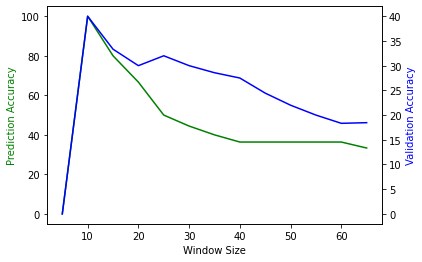

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ths_list, predictionsPercentageList, 'g-')
ax2.plot(ths_list, percentages_list, 'b-')

ax1.set_xlabel('Window Size')
ax1.set_ylabel('Prediction Accuracy', color='g')
ax2.set_ylabel('Validation Accuracy', color='b')

plt.show()

In [ ]:
list(set(df_conversations['Speaker']))

[0, 1, 2, 3, 4, 5]

In [ ]:
print(ths_list)
print(predictionsPercentageList)
print(percentages_list)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
[0.0, 100.0, 80.0, 66.66666666666667, 50.0, 44.44444444444444, 40.0, 36.36363636363637, 36.36363636363637, 36.36363636363637, 36.36363636363637, 36.36363636363637, 33.333333333333336]
[0.0, 40.0, 33.333333333333336, 30.0, 32.0, 30.0, 28.571428571428573, 27.5, 24.444444444444443, 22.0, 20.0, 18.333333333333332, 18.46153846153846]


In [ ]:
print(len(df_conversations))

68
